In [5]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
%matplotlib inline

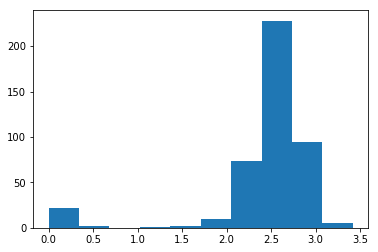

In [2]:
spec_atr_16 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/spec_atr.txt'
                         , format = 'ascii') 

spec_atr_17 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt'
                         , format = 'ascii') 

z_16 = [entry["zspec"] for entry in spec_atr_16]

z_17 = [entry["col5"] for entry in spec_atr_17]

plt.hist(z_17)
plt.show()

In [3]:
#an initial filter to ensure the spec included cover lya
basestring_16 = '/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/'

init_spec_16 = []

init_z_16 = []
    
for entry in spec_atr_16:
    
    if 2.5 < entry["zspec"] < 3.00: 
        
        temp = XSpectrum1D.from_file(basestring_16 + entry["Filename"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z_16.append(entry["zspec"])
                
            init_spec_16.append(XSpectrum1D.from_file(basestring_16 + entry["Filename"]))

In [4]:
#an initial filter to ensure the spec included cover lya
basestring_17 = '/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/spec_v0/'

init_spec_17 = []

init_z_17 = []
    
for entry in spec_atr_17:
    
    if 2.5 < entry["col5"] < 3.00: 
        
        temp = XSpectrum1D.from_file(basestring_17 + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z_17.append(entry["col5"])
                
            init_spec_17.append(XSpectrum1D.from_file(basestring_17 + entry["col1"]))

In [5]:
spec = np.asarray(init_spec_16 + init_spec_17)

print("Number of spectra (Nspec) after filter =", len(spec))

red = np.asarray(init_z_16 + init_z_17)

Number of spectra (Nspec) after filter = 307


In [6]:
# the normalization
r_2  = range(len(spec))

temp_2 = [np.asarray(spec[i].wavelength/(1+red[i])) for i in r_2]

wv_norm = [ (1410 < entry) & (entry < 1470) for entry in temp_2 ]

rough_med = np.asarray([np.median(spec[i].flux[wv_norm[i]]) for i in r_2])

g_med = [median > 0.0 for median in rough_med]

medians = rough_med[g_med]

g_spec = spec[g_med]

g_red = red[g_med]

r_3 = range(len(g_spec))

norm_flux = np.asarray([(g_spec[i].flux/medians[i]) for i in r_3])

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
#the new scaled Xspec objects

scaled_spec = []

for i in r_3:       
    
    scaled_spec.append(XSpectrum1D(g_spec[i].wavelength,norm_flux[i],sig=g_spec[i].sig))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [8]:
#the first trim on the wavelegth array to ensure a solid stack

trim_spec = []

for i in range(len(scaled_spec)):       
    
    trim_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][440:1500],
                                scaled_spec[i].data["flux"][0][440:1500],
                                scaled_spec[i].data["sig"][0][440:1500]))

collate = ltsu.collate(trim_spec)

print("Number of spectra to be stacked =", collate.nspec)

Number of spectra to be stacked = 243


/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [9]:
#rest frame wave values
rest_spec = ltsu.rebin_to_rest(collate,g_red, 200*u.km/u.s,grow_bad_sig = True)

stack = ltsu.smash_spectra(rest_spec)

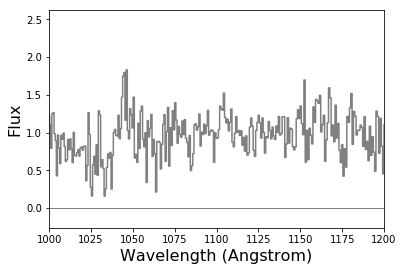

In [12]:
stack.plot(xlim=(1000,1200))

In [11]:
stack.write_to_fits("composite_3.0.fits")

Wrote spectrum to composite_3.0.fits
